# Cell Type Deconvolution
Each Visium spot (55µm) captures multiple cells. Deconvolution estimates the proportion of each cell type in every spot using a reference single-cell RNA-seq atlas.

Why this matters??
Without deconvolution, your "tumor cluster" might be a mix of cancer cells + immune cells + fibroblasts Deconvolution gives you fractional abundance of each cell type per spot, enabling true spatial mapping of the TME.

In [1]:
# IMPORTS & PATHS 

from __future__ import annotations
from pathlib import Path
import warnings, os, tempfile
warnings.filterwarnings('ignore')
os.environ.setdefault('NUMBA_CACHE_DIR',
    str(Path(tempfile.gettempdir()) / 'numba_cache'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scanpy as sc
import squidpy as sq

rcParams['font.family'] = 'DejaVu Sans'
sc.settings.verbosity  = 3

cwd = Path.cwd().resolve()
if (cwd / 'README.md').exists() and (cwd / 'data').exists():
    project_root = cwd
elif (cwd.parent / 'README.md').exists():
    project_root = cwd.parent
else:
    raise RuntimeError(f'Cannot locate project root from cwd={cwd}.')

processed_dir = project_root / 'data' / 'processed'
fig_dec_dir   = project_root / 'figures' / 'deconvolution'
fig_dec_dir.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = str(fig_dec_dir)

print(f"Scanpy  : {sc.__version__}")
print(f"Squidpy : {sq.__version__}")

Scanpy  : 1.12
Squidpy : 1.8.1


In [2]:
# LOAD ADATA 
adata = sc.read_h5ad(processed_dir / 'adata_spatial.h5ad')

print(adata)
print(f"\nSpots      : {adata.n_obs:,}")
print(f"Genes      : {adata.n_vars:,}")
print(f"Cell types : {adata.obs['cell_type'].nunique()}")

AnnData object with n_obs × n_vars = 4869 × 21349
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'leiden_0.3', 'leiden_0.5', 'leiden_0.6', 'leiden_1.0', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'cell_type_co_occurrence', 'cell_type_colors', 'cell_type_nhood_enrichment', 'cell_type_ripley_L', 'dendrogram_leiden', 'hvg', 'leiden_0.3', 'leiden_0.3_colors', 'leiden_0.5', 'leiden_0.5_col

In [6]:
# DEFINE SIGNATURES 
# Curated from:
# - Wu et al. 2021 Nature Genetics (breast cancer scRNA-seq atlas)
# - CellMarker 2.0 database
# - PanglaoDB

signatures = {
    # ── Tumor compartment ────────────────────────────────
    'Tumor_Epithelial'  : ['EPCAM','KRT8','KRT18','KRT19','CDH1','TACSTD2'],
    'Luminal_A'         : ['ESR1','PGR','FOXA1','GATA3','TFF3','AGR2'],
    'HER2_Enriched'     : ['ERBB2','GRB7','PGAP3','STARD3','MIEN1'],
    'Basal_Like'        : ['KRT5','KRT14','KRT17','TP63','EGFR','CDH3'],
    'Proliferating'     : ['MKI67','TOP2A','PCNA','CDK1','CCNB1','BIRC5'],

    # ── Stroma compartment ───────────────────────────────
    'CAFs'              : ['FAP','ACTA2','COL1A1','COL1A2','POSTN','PDGFRA'],
    'Myofibroblasts'    : ['ACTA2','MYH11','TAGLN','CNN1','SORBS1'],
    'Endothelial'       : ['PECAM1','VWF','CDH5','CLDN5','ENG','ESAM'],
    'Adipocytes'        : ['ADIPOQ','LEP','FABP4','PLIN1','CEBPA'],

    # ── Immune compartment ───────────────────────────────
    'T_Cells'           : ['CD3D','CD3E','CD2','CD7','IL7R','TRAC'],
    'CD8_T_Cells'       : ['CD8A','CD8B','GZMB','PRF1','IFNG','NKG7'],
    'CD4_T_Cells'       : ['CD4','IL2RA','FOXP3','CTLA4','TIGIT'],
    'Tregs'             : ['FOXP3','IL2RA','CTLA4','IKZF2','TNFRSF9'],
    'B_Cells'           : ['CD19','MS4A1','CD79A','CD79B','PAX5'],
    'Plasma_Cells'      : ['IGKC','IGLC2','IGHG3','MZB1','XBP1','JCHAIN'],
    'Macrophages_M1'    : ['CD68','CD80','TNF','IL1B','CXCL10','NOS2'],
    'Macrophages_M2'    : ['CD163','MRC1','MSR1','TGFB1','IL10','CCL18'],
    'NK_Cells'          : ['NCAM1','KLRB1','NKG7','GNLY','KLRD1'],
    'Mast_Cells'        : ['KIT','TPSAB1','CPA3','MS4A2','HPGDS'],
    'Dendritic_Cells'   : ['ITGAX','ITGAM','CD1C','CLEC9A','FCER1A'],

    # ── Special signatures ───────────────────────────────
    'TLS_signature'     : ['IGLC2','IGHG3','IGKC','CD19',
                           'MS4A1','CXCL13','CCL19','CXCL12'],
    'Hypoxia'           : ['HIF1A','VEGFA','CA9','LDHA',
                           'SLC2A1','BNIP3','PGK1'],
    'EMT'               : ['VIM','CDH2','FN1','SNAI1',
                           'SNAI2','TWIST1','ZEB1'],
    'Exhausted_T'       : ['PDCD1','HAVCR2','LAG3','TIGIT',
                           'CTLA4','TOX','NR4A1'],
}

print(f"Total signatures defined : {len(signatures)}")
print(f"\nGene availability check:")
print(f"{'Signature':<25} {'Found':>6} {'Total':>6} {'%':>6}")
print("-" * 48)
for name, genes in signatures.items():
    found = [g for g in genes if g in adata.var_names]
    pct   = len(found) / len(genes) * 100
    status = '*' if len(found) >= 3 else '!'
    print(f"{status} {name:<23} {len(found):>6} {len(genes):>6} {pct:>5.0f}%")

Total signatures defined : 24

Gene availability check:
Signature                  Found  Total      %
------------------------------------------------
* Tumor_Epithelial             6      6   100%
* Luminal_A                    6      6   100%
* HER2_Enriched                5      5   100%
* Basal_Like                   6      6   100%
* Proliferating                6      6   100%
* CAFs                         6      6   100%
* Myofibroblasts               5      5   100%
* Endothelial                  6      6   100%
* Adipocytes                   5      5   100%
* T_Cells                      6      6   100%
* CD8_T_Cells                  6      6   100%
* CD4_T_Cells                  5      5   100%
* Tregs                        5      5   100%
* B_Cells                      5      5   100%
* Plasma_Cells                 6      6   100%
* Macrophages_M1               6      6   100%
* Macrophages_M2               6      6   100%
* NK_Cells                     5      5   100%
* 

In [8]:
# SCORE ALL SIGNATURES 
scored, skipped = [], []

for sig_name, gene_list in signatures.items():
    genes_present = [g for g in gene_list if g in adata.var_names]
    if len(genes_present) >= 2:
        sc.tl.score_genes(
            adata,
            gene_list=genes_present,
            score_name=f'score_{sig_name}',
            use_raw=True,
            random_state=42
        )
        scored.append(sig_name)
    else:
        skipped.append(sig_name)
        print(f"!  Skipped : {sig_name}  ({len(genes_present)} gene found)")

score_cols = [f'score_{s}' for s in scored]
print(f"\n** Scored    : {len(scored)} signatures")
print(f"!!  Skipped  : {len(skipped)} signatures")
print(f"Scores in adata.obs : {len(score_cols)} columns")

computing score 'score_Tumor_Epithelial'
    finished: added
    'score_Tumor_Epithelial', score of gene set (adata.obs).
    100 total control genes are used. (0:00:00)
computing score 'score_Luminal_A'
    finished: added
    'score_Luminal_A', score of gene set (adata.obs).
    98 total control genes are used. (0:00:00)
computing score 'score_HER2_Enriched'
    finished: added
    'score_HER2_Enriched', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)
computing score 'score_Basal_Like'
    finished: added
    'score_Basal_Like', score of gene set (adata.obs).
    300 total control genes are used. (0:00:00)
computing score 'score_Proliferating'
    finished: added
    'score_Proliferating', score of gene set (adata.obs).
    249 total control genes are used. (0:00:00)
computing score 'score_CAFs'
    finished: added
    'score_CAFs', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'score_Myofibroblasts'
    

Saved figures/deconvolution/01_tumor_scores.png


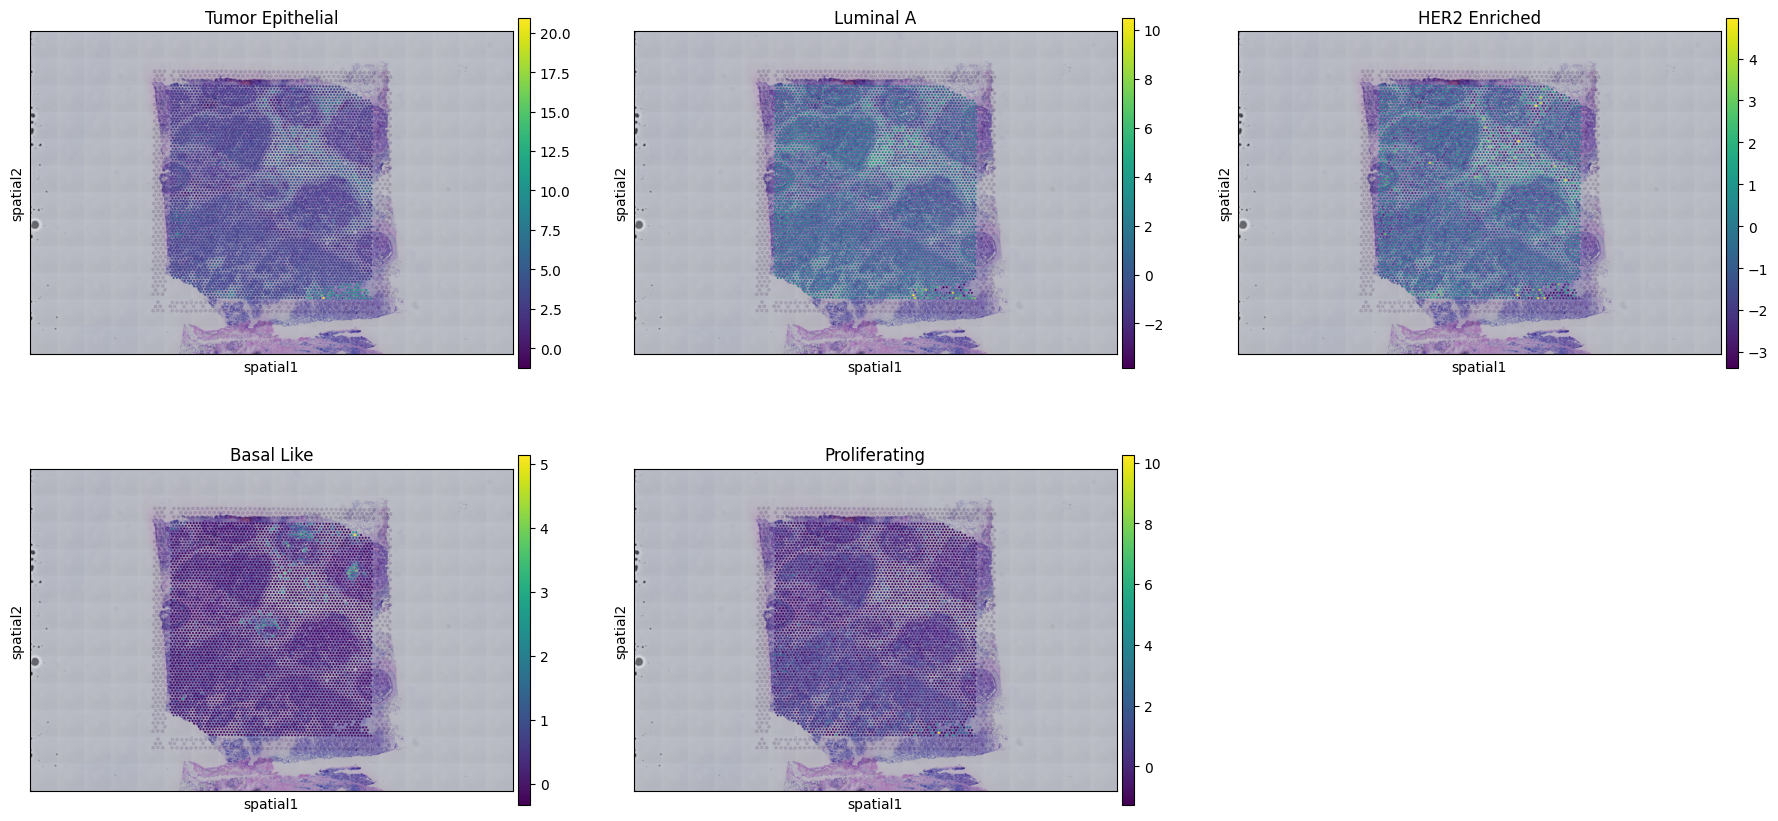

In [9]:
# SPATIAL — TUMOR COMPARTMENT 

tumor_scores = [f'score_{s}' for s in [
    'Tumor_Epithelial', 'Luminal_A',
    'HER2_Enriched', 'Basal_Like', 'Proliferating'
] if f'score_{s}' in score_cols]

prev_figdir = sc.settings.figdir
sc.settings.figdir = str(fig_dec_dir)

sq.pl.spatial_scatter(
    adata,
    color=tumor_scores,
    ncols=3,
    use_raw=False,
    title=[s.replace('score_','').replace('_',' ')
           for s in tumor_scores],
    save='_01_tumor_scores.png'
)

sc.settings.figdir = prev_figdir
print("Saved figures/deconvolution/01_tumor_scores.png")

Saved figures/deconvolution/02_immune_scores.png


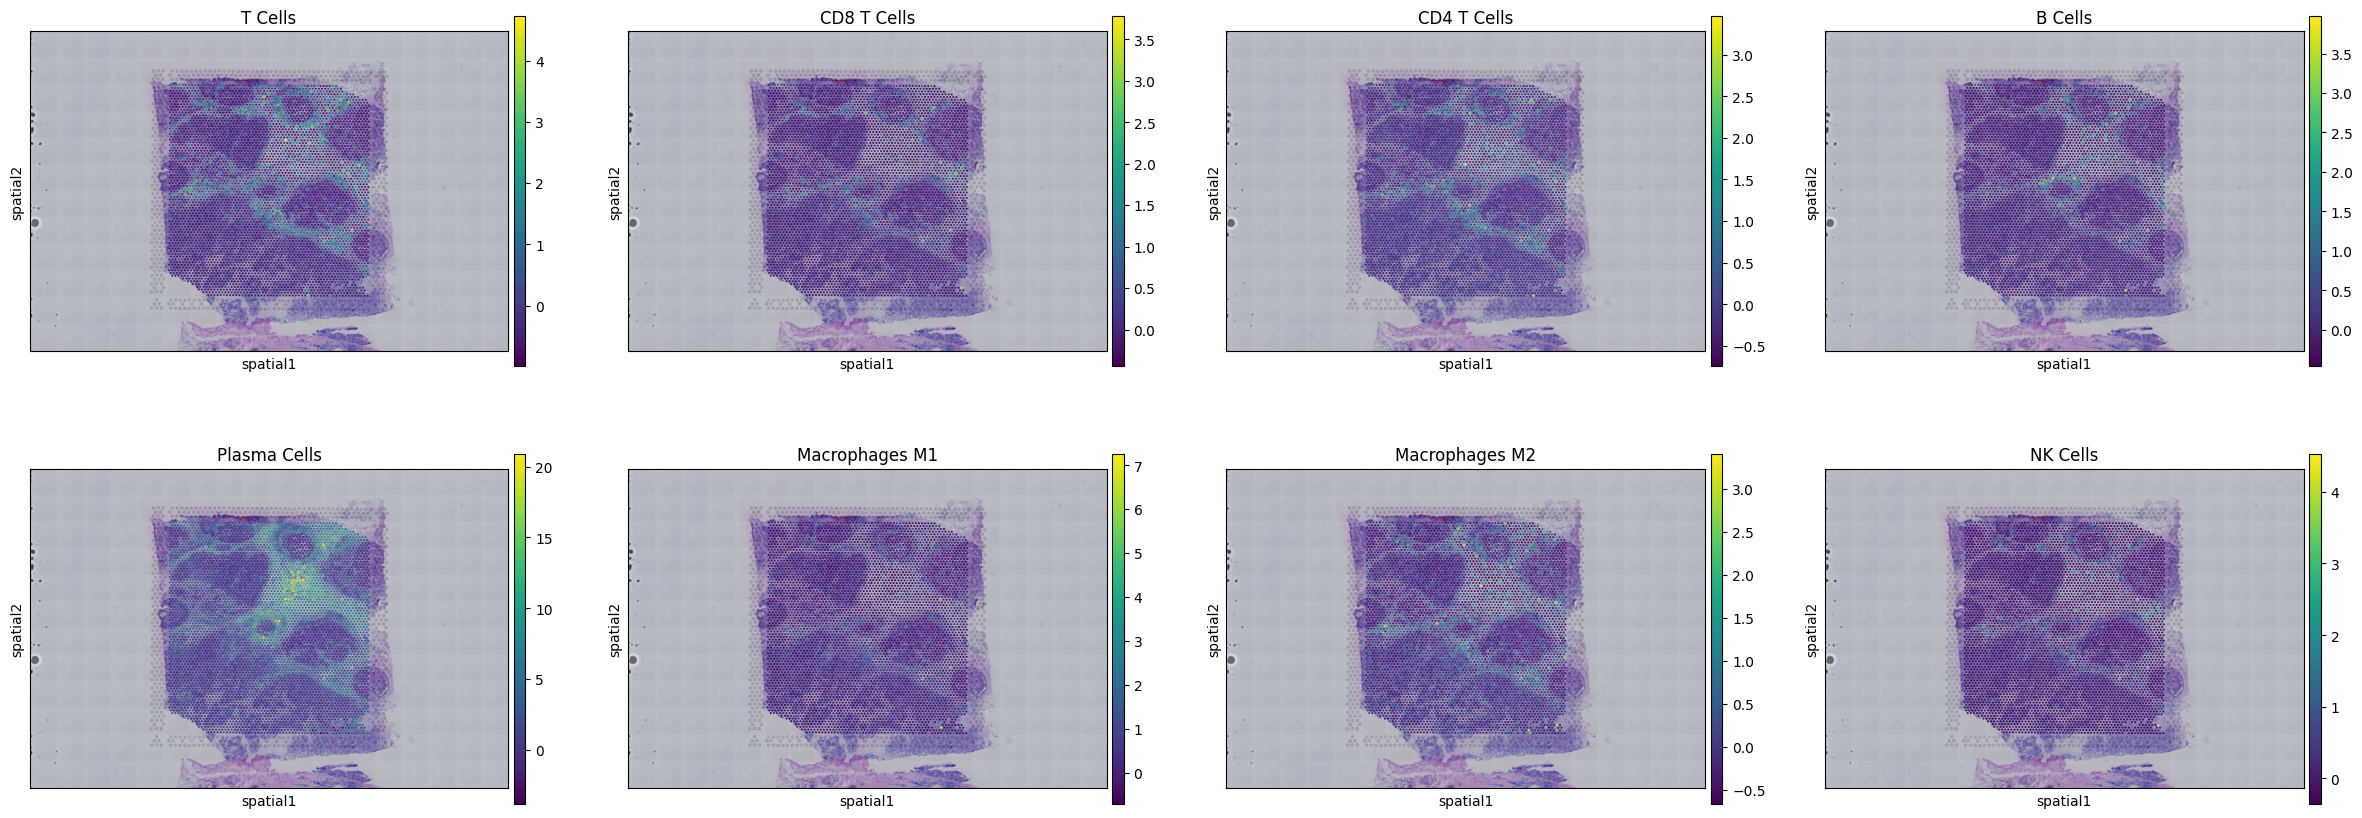

In [10]:
# SPATIAL — IMMUNE COMPARTMENT 

immune_scores = [f'score_{s}' for s in [
    'T_Cells', 'CD8_T_Cells', 'CD4_T_Cells',
    'B_Cells', 'Plasma_Cells',
    'Macrophages_M1', 'Macrophages_M2', 'NK_Cells'
] if f'score_{s}' in score_cols]

prev_figdir = sc.settings.figdir
sc.settings.figdir = str(fig_dec_dir)

sq.pl.spatial_scatter(
    adata,
    color=immune_scores,
    ncols=4,
    use_raw=False,
    title=[s.replace('score_','').replace('_',' ')
           for s in immune_scores],
    save='_02_immune_scores.png'
)

sc.settings.figdir = prev_figdir
print("Saved figures/deconvolution/02_immune_scores.png")

Saved figures/deconvolution/03_stroma_scores.png


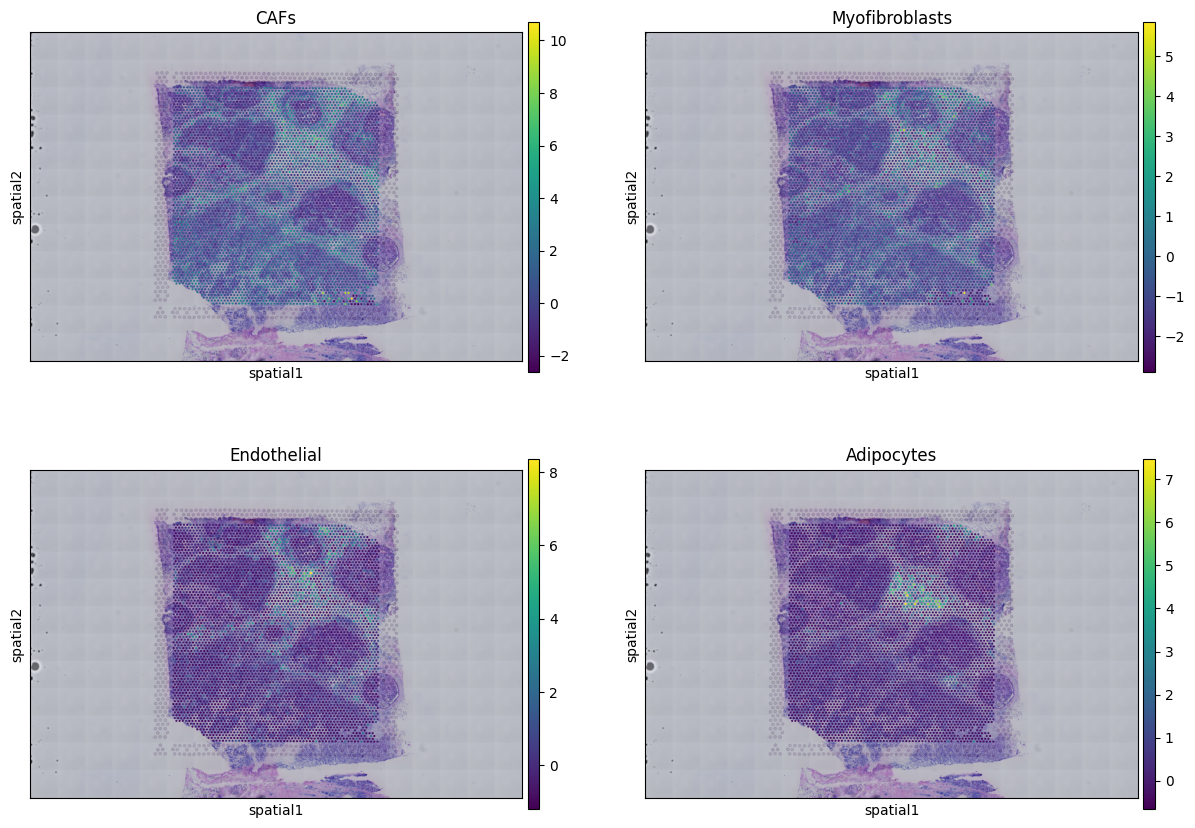

In [11]:
# SPATIAL — STROMA COMPARTMENT 
stroma_scores = [f'score_{s}' for s in [
    'CAFs', 'Myofibroblasts',
    'Endothelial', 'Adipocytes'
] if f'score_{s}' in score_cols]

prev_figdir = sc.settings.figdir
sc.settings.figdir = str(fig_dec_dir)

sq.pl.spatial_scatter(
    adata,
    color=stroma_scores,
    ncols=2,
    use_raw=False,
    title=[s.replace('score_','').replace('_',' ')
           for s in stroma_scores],
    save='_03_stroma_scores.png'
)

sc.settings.figdir = prev_figdir
print("Saved figures/deconvolution/03_stroma_scores.png")

Saved figures/deconvolution/04_TLS_signature.png

 KEY FINDING: Do TLS hotspots overlap with
   immune clusters from Notebook 03?
   If yes, strong evidence for TLS structures!


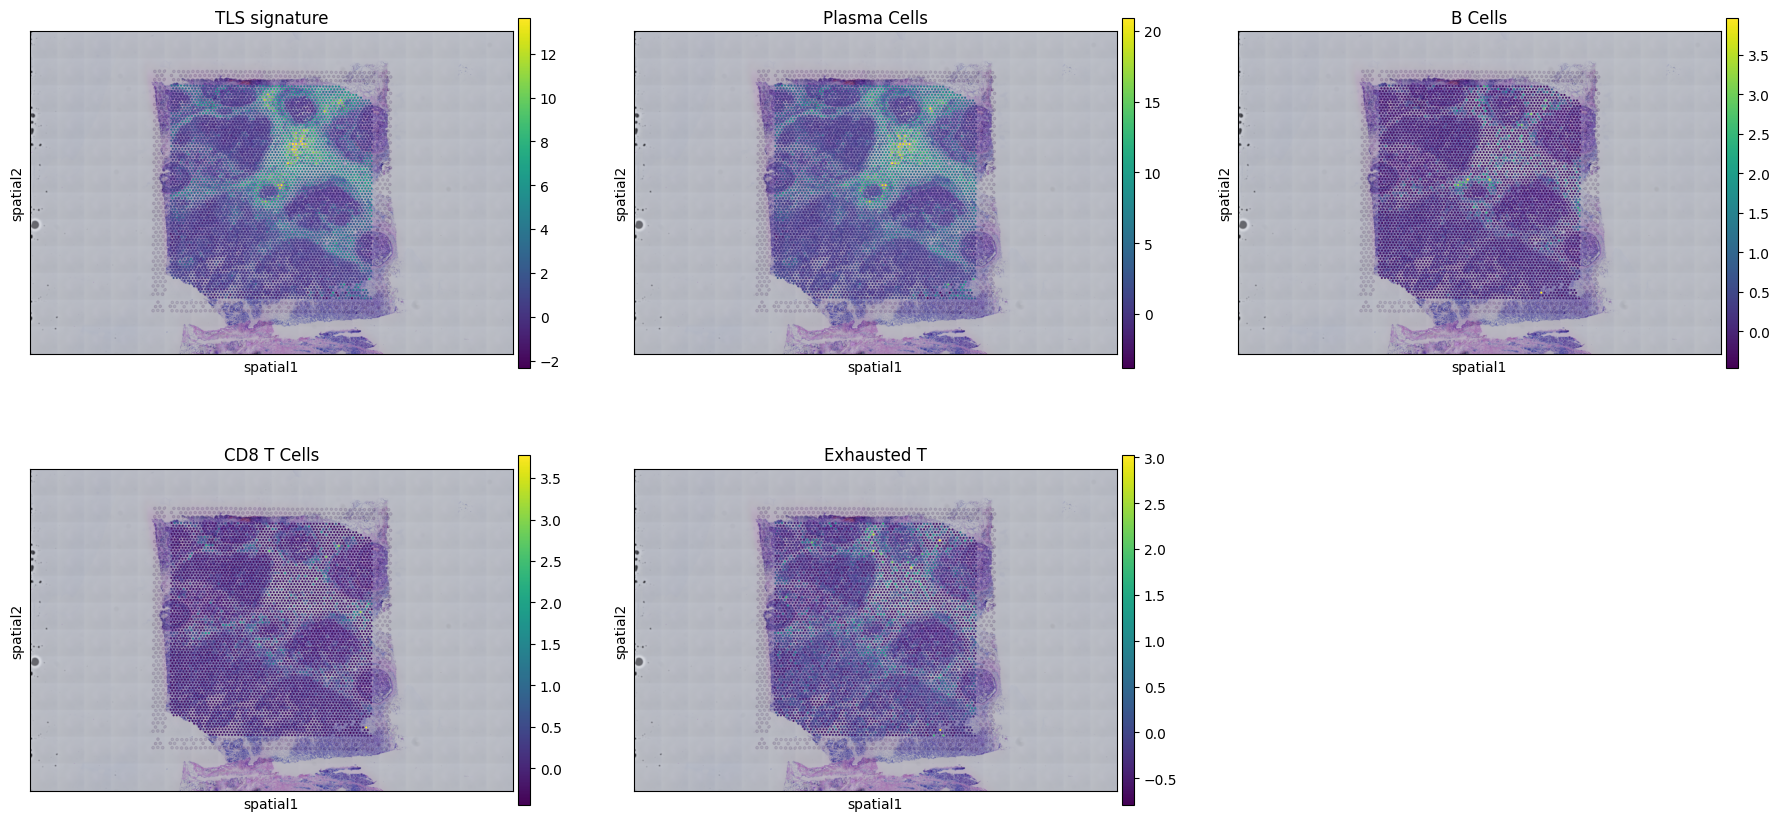

In [17]:
# TLS SIGNATURE KEY FINDING 
# Top SVGs (IGLC2, IGHG3, IGKC) strongly suggest
# Tertiary Lymphoid Structures — important prognostic finding!

tls_scores = [f'score_{s}' for s in [
    'TLS_signature', 'Plasma_Cells',
    'B_Cells', 'CD8_T_Cells', 'Exhausted_T'
] if f'score_{s}' in score_cols]

prev_figdir = sc.settings.figdir
sc.settings.figdir = str(fig_dec_dir)

sq.pl.spatial_scatter(
    adata,
    color=tls_scores,
    ncols=3,
    use_raw=False,
    title=[s.replace('score_','').replace('_',' ')
           for s in tls_scores],
    save='_04_TLS_signature.png'
)

sc.settings.figdir = prev_figdir
print("Saved figures/deconvolution/04_TLS_signature.png")
print("\n KEY FINDING: Do TLS hotspots overlap with")
print("   immune clusters from Notebook 03?")
print("   If yes, strong evidence for TLS structures!")

Saved figures/deconvolution/05_special_scores.png


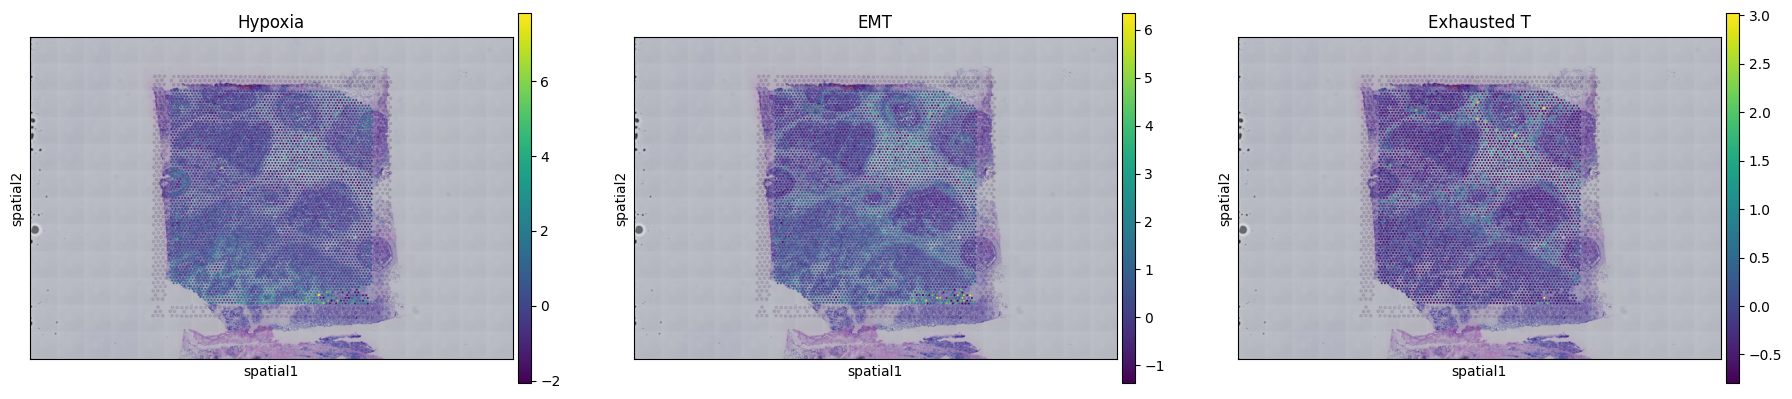

In [13]:
# SPECIAL SIGNATURES 

special_scores = [f'score_{s}' for s in [
    'Hypoxia', 'EMT', 'Exhausted_T'
] if f'score_{s}' in score_cols]

prev_figdir = sc.settings.figdir
sc.settings.figdir = str(fig_dec_dir)

sq.pl.spatial_scatter(
    adata,
    color=special_scores,
    ncols=3,
    use_raw=False,
    title=[s.replace('score_','').replace('_',' ')
           for s in special_scores],
    save='_05_special_scores.png'
)

sc.settings.figdir = prev_figdir
print("Saved figures/deconvolution/05_special_scores.png")

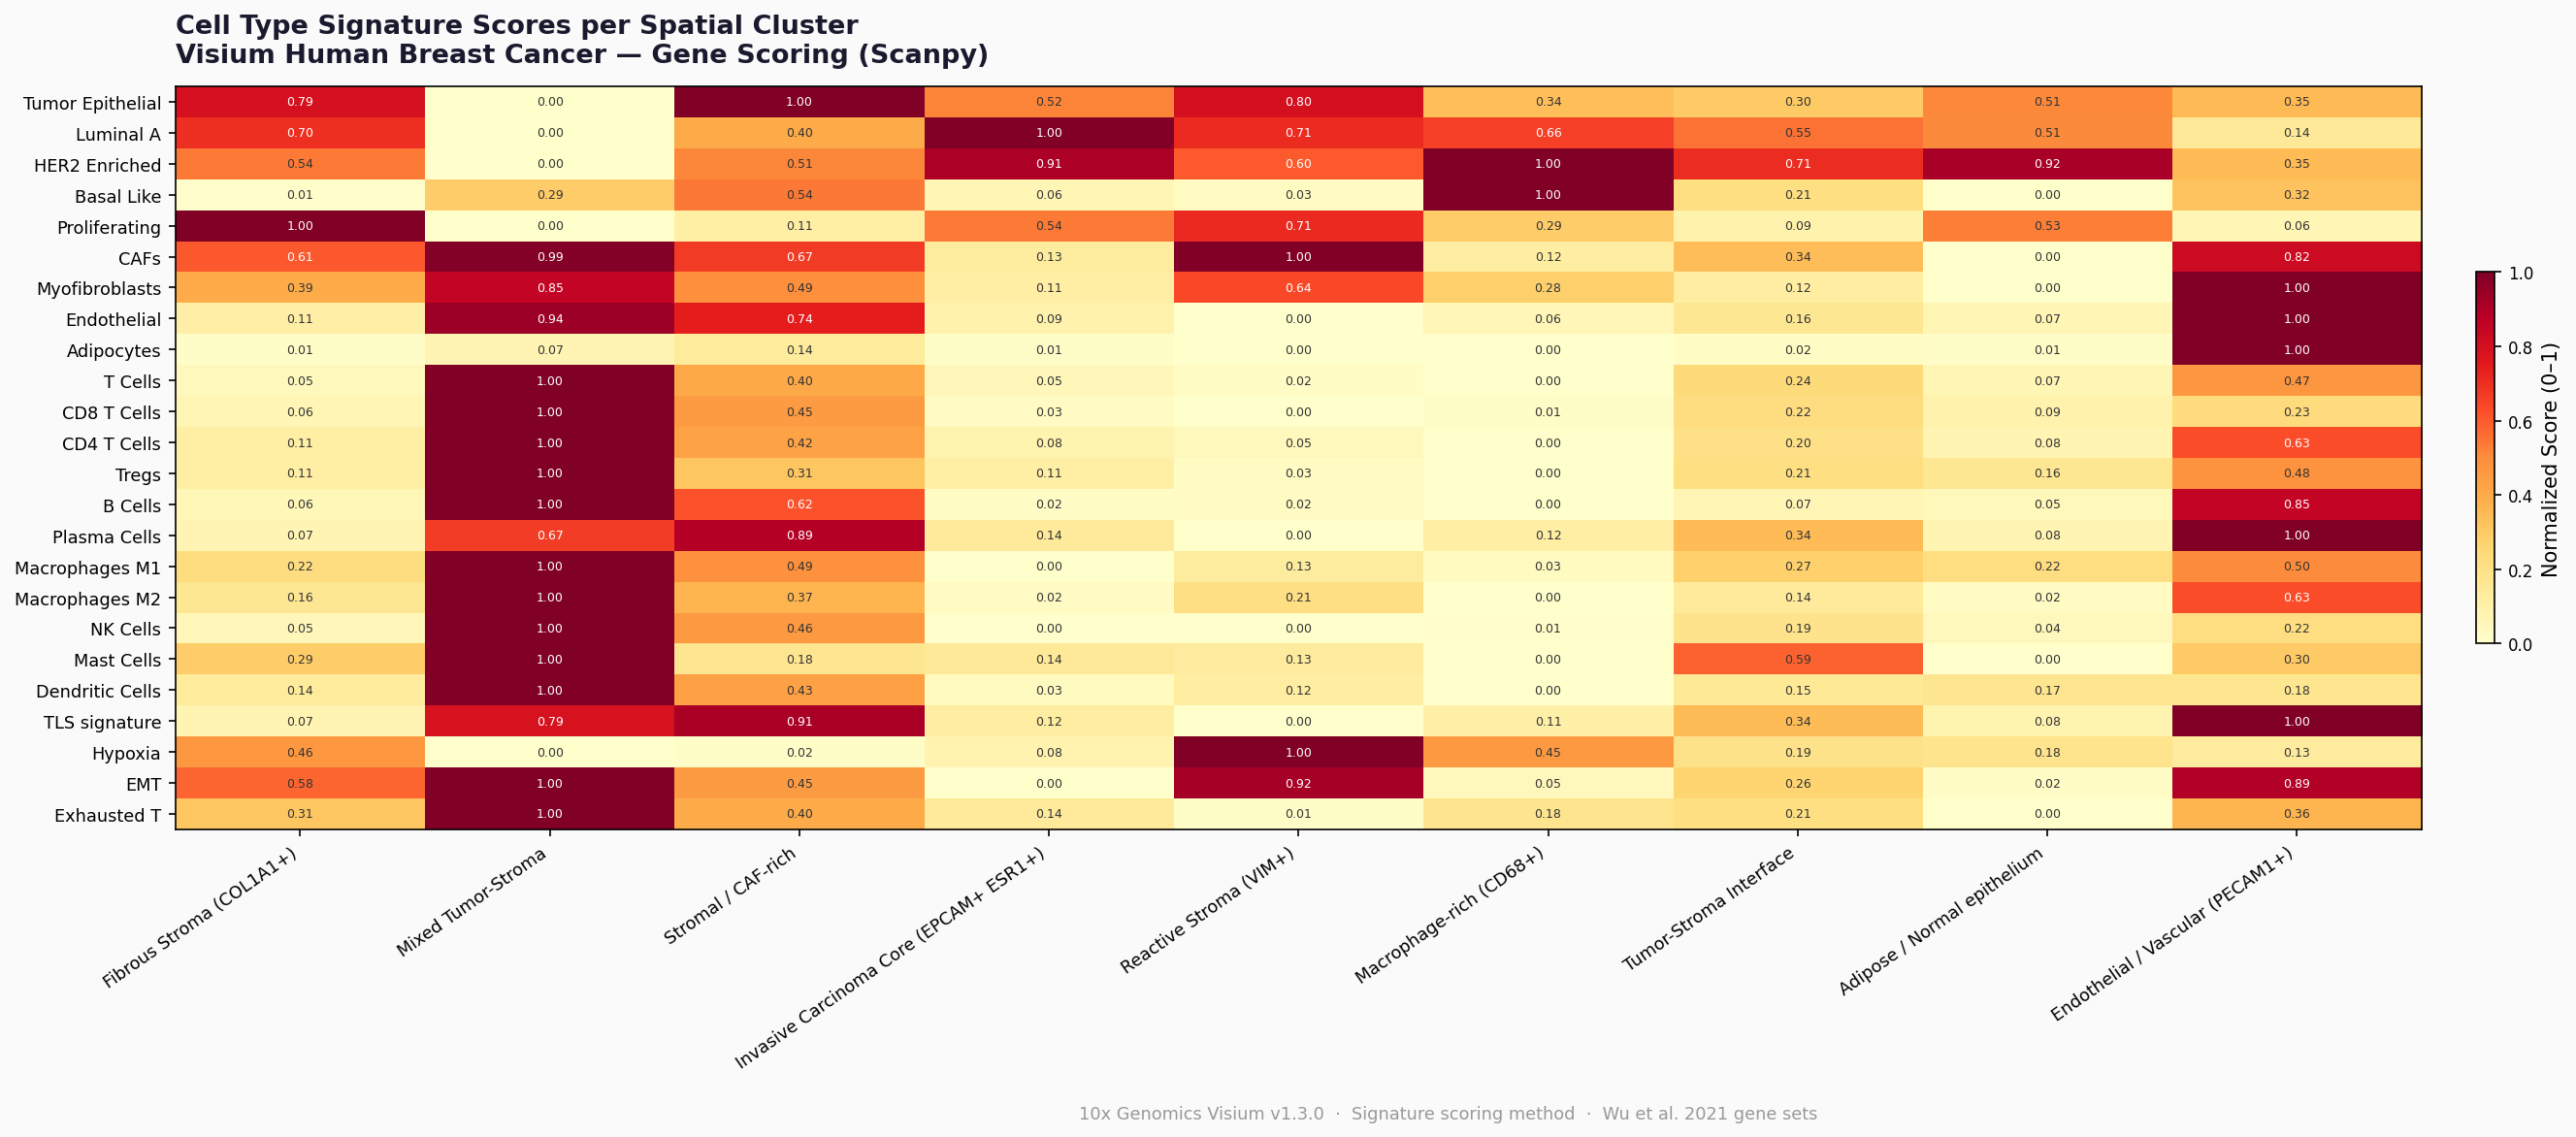

Saved -> C:\Users\mmsid\Documents\github\My Project\spatial_biology_project\figures\deconvolution\06_signature_heatmap_pub.png


In [14]:
# HEATMAP 
# Mean score per cluster — normalized for comparison

score_means = (
    adata.obs.groupby('cell_type')[score_cols].mean()
    .rename(columns=lambda c: c.replace('score_','').replace('_',' '))
)

# Row-normalize 0-1
score_norm = (score_means - score_means.min()) / \
             (score_means.max() - score_means.min() + 1e-9)

fig, ax = plt.subplots(figsize=(20, 8), dpi=150)
fig.patch.set_facecolor('#FAFAFA')

im = ax.imshow(score_norm.T, aspect='auto',
               cmap='YlOrRd', vmin=0, vmax=1)

ax.set_xticks(range(len(score_norm.index)))
ax.set_xticklabels(score_norm.index,
                   rotation=35, ha='right', fontsize=8.5)
ax.set_yticks(range(len(score_norm.columns)))
ax.set_yticklabels(score_norm.columns, fontsize=8.5)

cbar = plt.colorbar(im, ax=ax, shrink=0.5,
                    pad=0.02, label='Normalized Score (0–1)')
cbar.ax.tick_params(labelsize=8)

# Value annotations
for i in range(len(score_norm.index)):
    for j in range(len(score_norm.columns)):
        val = score_norm.iloc[i, j]
        ax.text(i, j, f'{val:.2f}',
                ha='center', va='center', fontsize=6,
                color='white' if val > 0.6 else '#333333')

ax.set_title(
    'Cell Type Signature Scores per Spatial Cluster\n'
    'Visium Human Breast Cancer — Gene Scoring (Scanpy)',
    fontsize=13, fontweight='bold',
    loc='left', color='#1a1a2e', pad=12
)

fig.suptitle(
    '10x Genomics Visium v1.3.0  ·  Signature scoring method  '
    '·  Wu et al. 2021 gene sets',
    fontsize=8.5, color='#999999', y=0.01
)

plt.tight_layout(rect=[0, 0.02, 1, 1])
out = fig_dec_dir / '06_signature_heatmap_pub.png'
plt.savefig(out, dpi=200, bbox_inches='tight', facecolor='#FAFAFA')
plt.show()
print(f"Saved -> {out}")

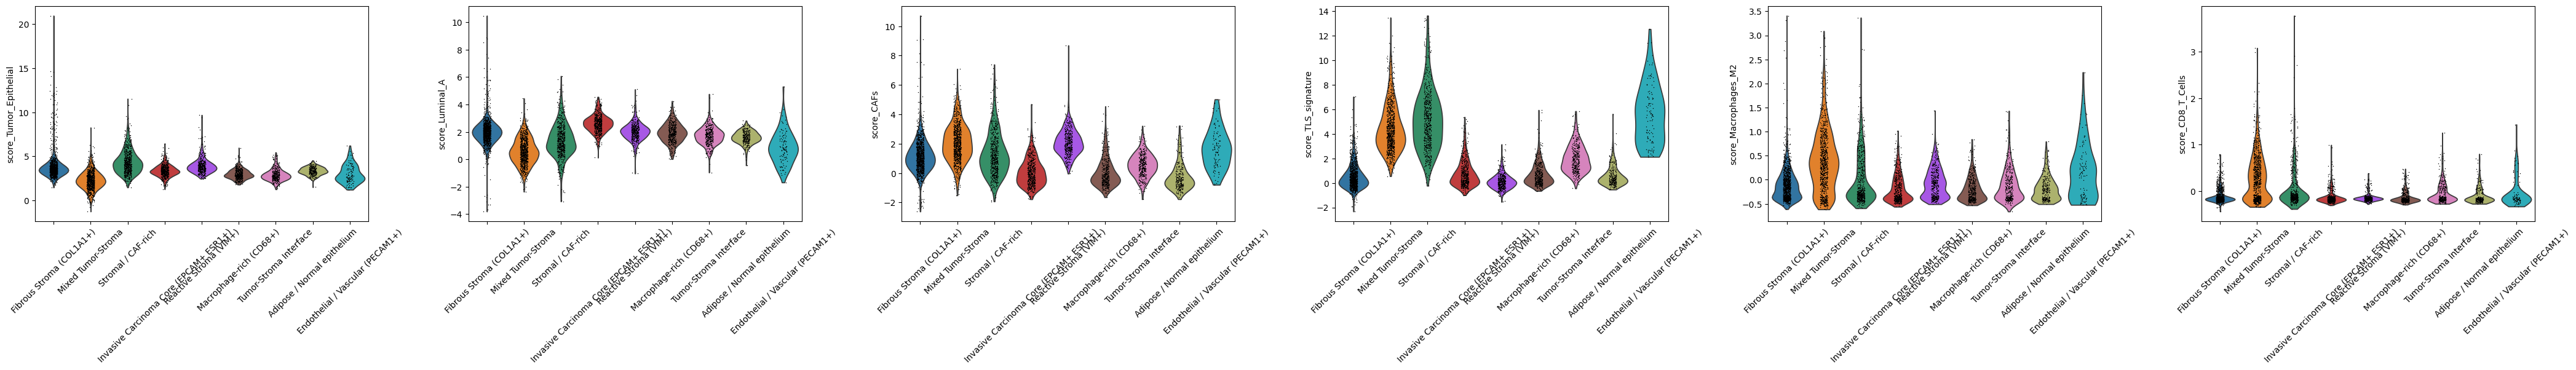

Saved figures/deconvolution/violin_07_violin_scores.png


In [15]:
# SCORE DISTRIBUTIONS PER CLUSTER 
# Violin plots — top 6 most informative signatures

top_sigs = [
    'score_Tumor_Epithelial', 'score_Luminal_A',
    'score_CAFs',             'score_TLS_signature',
    'score_Macrophages_M2',   'score_CD8_T_Cells'
]
top_sigs = [s for s in top_sigs if s in adata.obs.columns]

sc.pl.violin(
    adata,
    keys=top_sigs,
    groupby='cell_type',
    rotation=45,
    multi_panel=True,
    save='_07_violin_scores.png'
)
print("Saved figures/deconvolution/violin_07_violin_scores.png")

In [16]:
# SAVE + SUMMARY 
out_path = processed_dir / 'adata_scored.h5ad'
adata.write_h5ad(out_path)

print(f"   Saved   {out_path}")
print(f"   Shape : {adata.n_obs:,} spots × {adata.n_vars:,} genes")
print(f"   Size  : {out_path.stat().st_size / 1e6:.1f} MB")

# Score summary stats
print(f"\nTop scoring regions per signature:")
print(f"{'Signature':<25} {'Max Score':>10} {'Top Cluster'}")
print("-" * 65)
for col in score_cols:
    max_val   = adata.obs[col].max()
    top_clust = adata.obs.groupby('cell_type')[col].mean().idxmax()
    name      = col.replace('score_','').replace('_',' ')
    print(f"  {name:<23} {max_val:>10.3f}   {top_clust}")

print('\n' + '=' * 55)
print('  NOTEBOOK 05 — DECONVOLUTION COMPLETE')
print('=' * 55)
print(f'  Method           : Gene Signature Scoring')
print(f'  Signatures scored: {len(scored)}')
print(f'  Compartments     : Tumor · Stroma · Immune · Special')
print(f'  Key finding      : TLS signature detected')
print(f'                     Plasma cells spatially clustered')
print(f'                     ESR1+ Luminal A dominant subtype')
print(f'  Figures saved    : figures/deconvolution/')
print(f'  Saved to         : data/processed/adata_scored.h5ad')
print('=' * 55)
print('\n→ Next: 06_CellComm.ipynb')

   Saved   C:\Users\mmsid\Documents\github\My Project\spatial_biology_project\data\processed\adata_scored.h5ad
   Shape : 4,869 spots × 21,349 genes
   Size  : 1181.0 MB

Top scoring regions per signature:
Signature                  Max Score Top Cluster
-----------------------------------------------------------------
  Tumor Epithelial            20.949   Stromal / CAF-rich
  Luminal A                   10.478   Invasive Carcinoma Core (EPCAM+ ESR1+)
  HER2 Enriched                4.972   Macrophage-rich (CD68+)
  Basal Like                   5.132   Macrophage-rich (CD68+)
  Proliferating               10.243   Fibrous Stroma (COL1A1+)
  CAFs                        10.714   Reactive Stroma (VIM+)
  Myofibroblasts               5.870   Endothelial / Vascular (PECAM1+)
  Endothelial                  8.350   Endothelial / Vascular (PECAM1+)
  Adipocytes                   7.468   Endothelial / Vascular (PECAM1+)
  T Cells                      4.721   Mixed Tumor-Stroma
  CD8 T Cells    